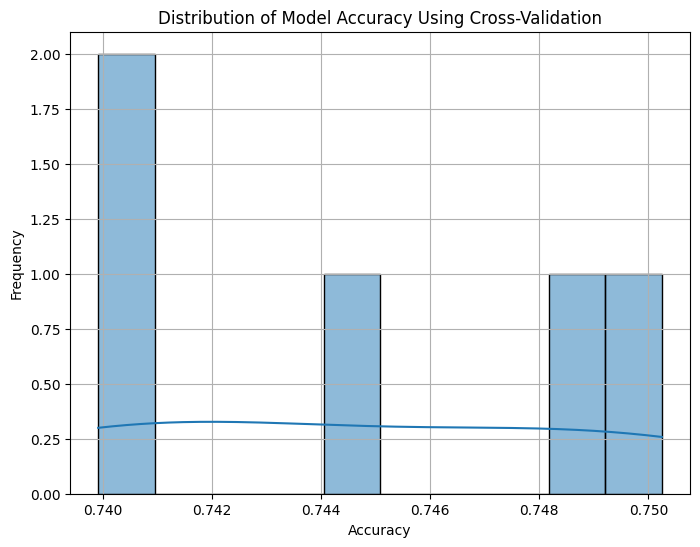

Iteration 1: Accuracy = 0.74
Iteration 2: Accuracy = 0.73
Iteration 3: Accuracy = 0.75
Iteration 4: Accuracy = 0.74
Iteration 5: Accuracy = 0.76


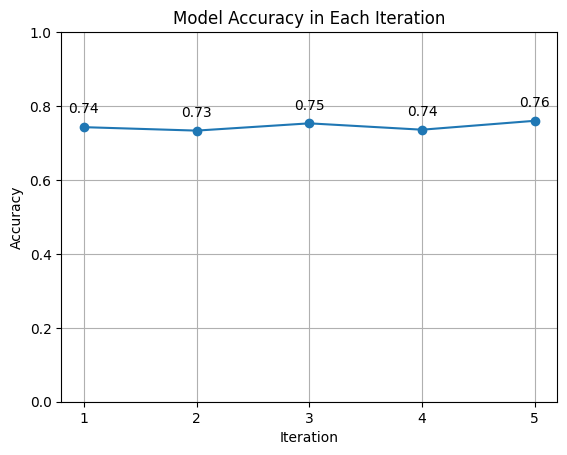

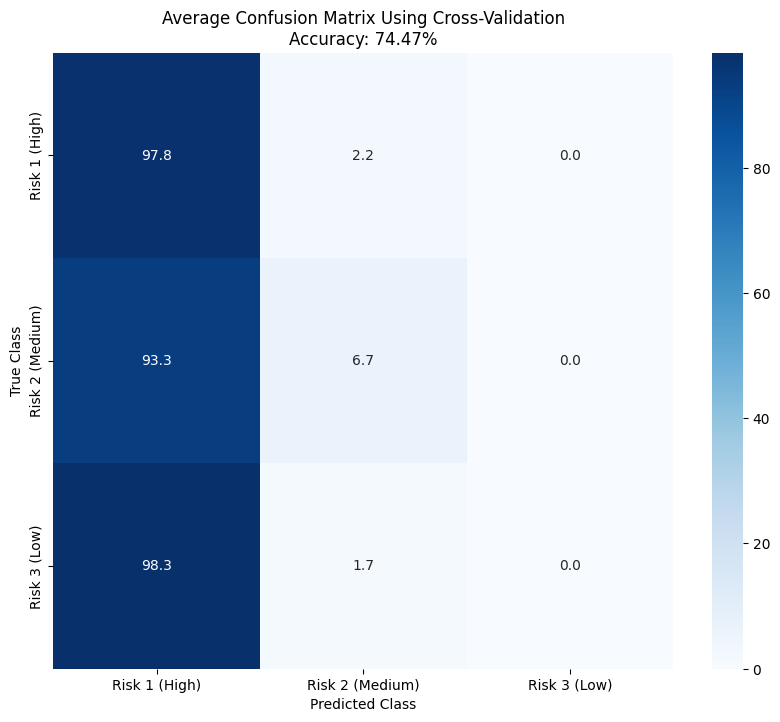

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

# Load the data
db_path = "/content/restaurant.sqlite"
conn = sqlite3.connect(db_path)
query = "SELECT * FROM restaurants"
df_stocks = pd.read_sql_query(query, conn)
conn.close()

# Convert 'Risk' column to numerical using LabelEncoder
label_encoder = LabelEncoder()
df_stocks["Risk"] = label_encoder.fit_transform(df_stocks["Risk"].fillna("Unknown"))

# Select relevant features for prediction
features = ["Results", "zip"]

# Data preparation function
def prepare_data(df):
    X = df[features]
    y = df["Risk"]

    X_encoded = pd.get_dummies(X, columns=["Results", "zip"], drop_first=True)
    imputer = SimpleImputer(strategy="mean")
    X_encoded_imputed = imputer.fit_transform(X_encoded)
    return X_encoded_imputed, y

# Model evaluation function
def evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    return scores

# Train and evaluate the model
X, y = prepare_data(df_stocks)
model = RandomForestClassifier(n_estimators=100, random_state=42)
accuracy_scores = evaluate_model(model, X, y)

# Plot the accuracy distribution
plt.figure(figsize=(8, 6))
sns.histplot(accuracy_scores, bins=10, kde=True)
plt.title("Distribution of Model Accuracy Using Cross-Validation")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

accuracy_list = []

for iteration in range(1, 6):  # Run the model 5 times with different data splits
    # Shuffle the data
    df_shuffled = df_stocks.sample(frac=1, random_state=np.random.randint(1, 100))

    X = df_shuffled[features]
    y = df_shuffled["Risk"]

    X_encoded = pd.get_dummies(X, columns=["Results", "zip"], drop_first=True)
    imputer = SimpleImputer(strategy="mean")
    X_encoded_imputed = imputer.fit_transform(X_encoded)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded_imputed, y, test_size=0.2, random_state=np.random.randint(1, 100))

    model = RandomForestClassifier(n_estimators=100, random_state=np.random.randint(1, 100))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate accuracy for the current iteration
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy to a list
    accuracy_list.append(accuracy)

    # Print accuracy for the current iteration
    print(f"Iteration {iteration}: Accuracy = {accuracy:.2f}")



# Add labels to the data points
for i, txt in enumerate(accuracy_list):
    plt.annotate(f"{txt:.2f}", (i + 1, accuracy_list[i]), textcoords="offset points", xytext=(0, 10), ha='center')



plt.plot(range(1, 6), accuracy_list, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Model Accuracy in Each Iteration')
plt.xticks(range(1, 6))
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Calculate the overall accuracy
total_correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)
accuracy = total_correct_predictions / total_predictions

# Generate and plot confusion matrix with percentages
conf_matrix_percent = (conf_matrix / conf_matrix.sum(axis=1, keepdims=True)) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Average Confusion Matrix Using Cross-Validation\nAccuracy: {accuracy:.2%}")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
